In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy_financial as npf
from pandas import Series, DataFrame

In [2]:
#dataset 01
data_01_01 = pd.read_csv('01_CO2_Emission_Sector.csv') #by กระทรวงพลังงาน
data_01_01 = data_01_01.fillna(0)
data_01_02 = pd.read_csv('01_CO2_Emission_kWh.csv', index_col = 'Year', parse_dates = True) #by กระทรวงพลังงาน

#display(data_01_01)
data_01_01.Year = data_01_01.Year.astype('object')
#data_01_01.info() 
#display(data_01_02)
#data_01_02.info()


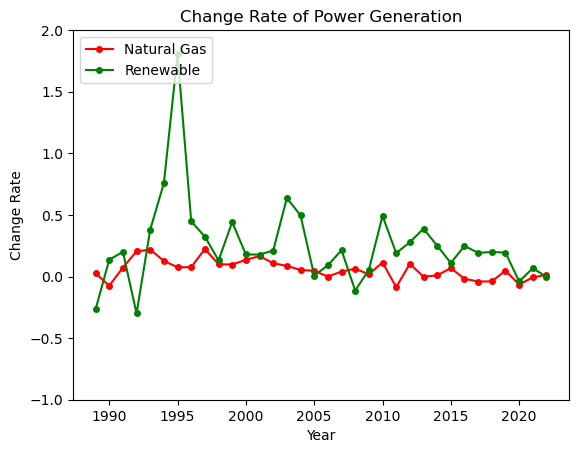

In [3]:
data_01_00 = pd.read_csv('01_Power.csv')
data_01_00['Type'].fillna(method='ffill', inplace = True)
#display(data_01_00)

df_ener = pd.DataFrame(set(data_01_00['Date']), columns=['Year'])
df_ener['Hydro'] = list(data_01_00[data_01_00['Type'].str.match('Hydro')]['Volume'])
df_ener['Fuel Oil'] = list(data_01_00[data_01_00['Type'].str.match('Fuel Oil')]['Volume'])
df_ener['Lignite'] = list(data_01_00[data_01_00['Type'].str.match('Lignite')]['Volume'])
df_ener['Natural Gas'] = list(data_01_00[data_01_00['Type'].str.match('Natural Gas')]['Volume'])
df_ener['Diesel'] = list(data_01_00[data_01_00['Type'].str.match('Diesel')]['Volume'])
df_ener['Imported'] = list(data_01_00[data_01_00['Type'].str.match('Imported')]['Volume'])
df_ener['Renewable'] = list(data_01_00[data_01_00['Type'].str.match('Renewable')]['Volume'])
col = df_ener.columns.values.tolist()[1:]
df_ener['Energy'] = df_ener[col].sum(axis = 1)
#display(df_ener)

data_01_00.dropna(inplace = True)
df_ener['g_natural'] = df_ener['Natural Gas'].pct_change()
df_ener['g_renew'] = df_ener['Renewable'].pct_change()
df_ener.dropna(inplace = True)
df_ener.drop([2], axis = 0, inplace = True)
#display(df_ener)

plt.plot(df_ener['Year'], df_ener['g_natural'], color = "r",marker = "o", markersize = 4, label="Natural Gas")
plt.plot(df_ener['Year'], df_ener['g_renew'], color = "g",marker = "o", markersize = 4, label="Renewable")

plt.legend(loc="upper left")
plt.ylim(-1.0, 2.0)
plt.title('Change Rate of Power Generation')
plt.xlabel('Year')
plt.ylabel('Change Rate')

plt.show()


<AxesSubplot:title={'center':'CO2 By Fuel'}, xlabel='Year', ylabel='1000 Tons'>

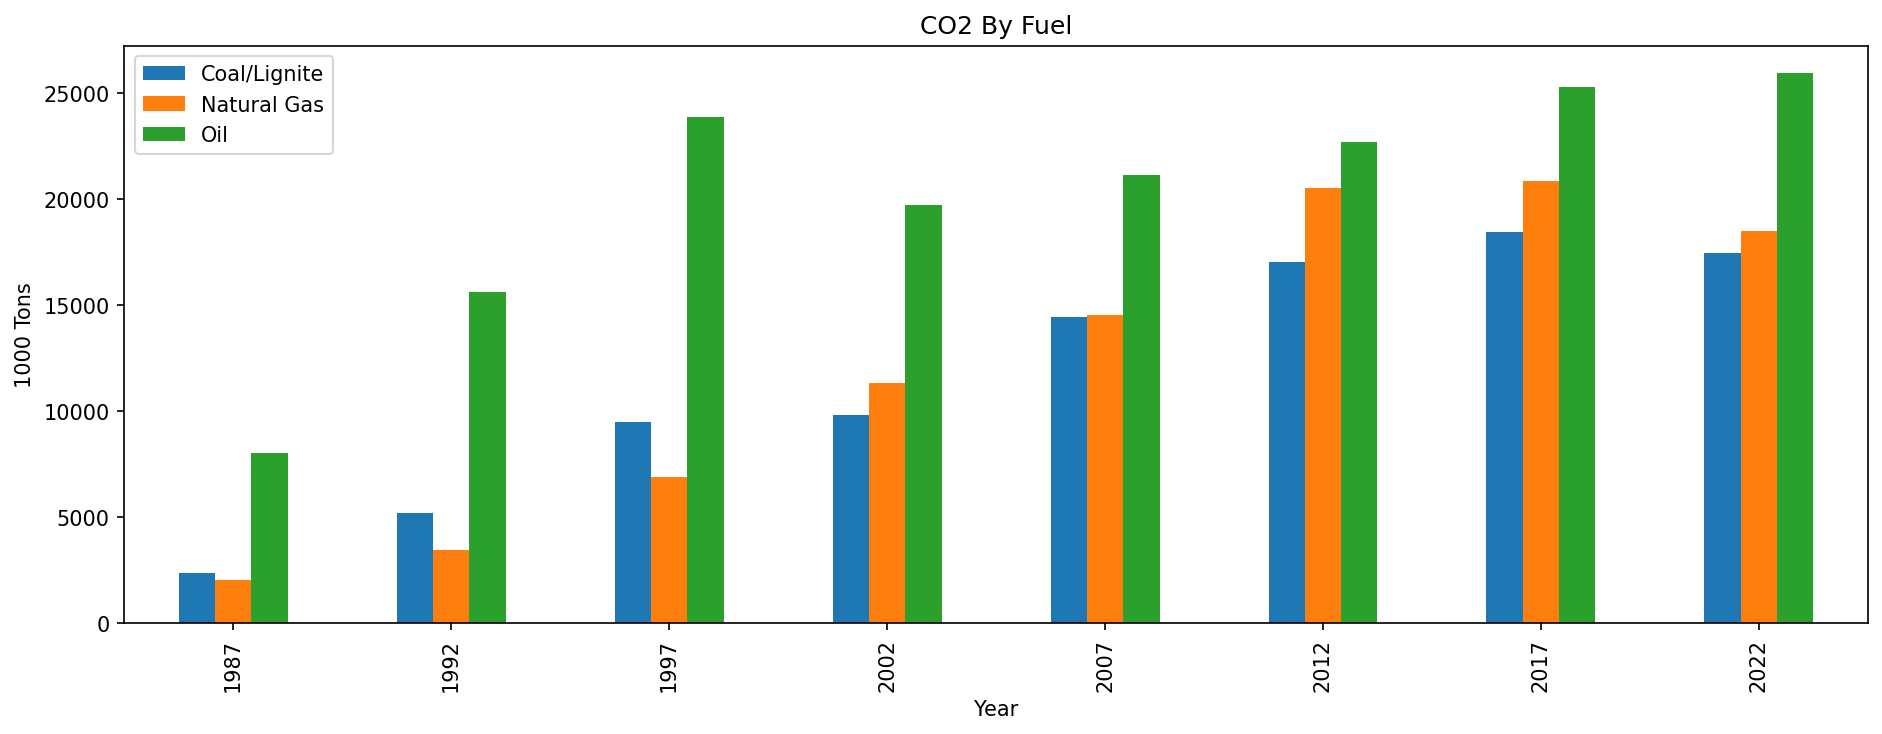

In [4]:
%matplotlib inline
df_res = data_01_01.pivot_table(index = ['Year'], values = ['Oil', 'Natural Gas', 'Coal/Lignite'])
#display(df_res)

plt.figure(figsize=(15,5),dpi=150)
ax = plt.gca()
df_res.iloc[::5, :].plot( kind='bar', ax=ax,
         title='CO2 By Fuel', ylabel='1000 Tons')

#เพิ่มเติมอัตราการเปลีี่ยนแปลง



<AxesSubplot:title={'center':'CO2 By Activity'}, xlabel='Year', ylabel='1000 Tons'>

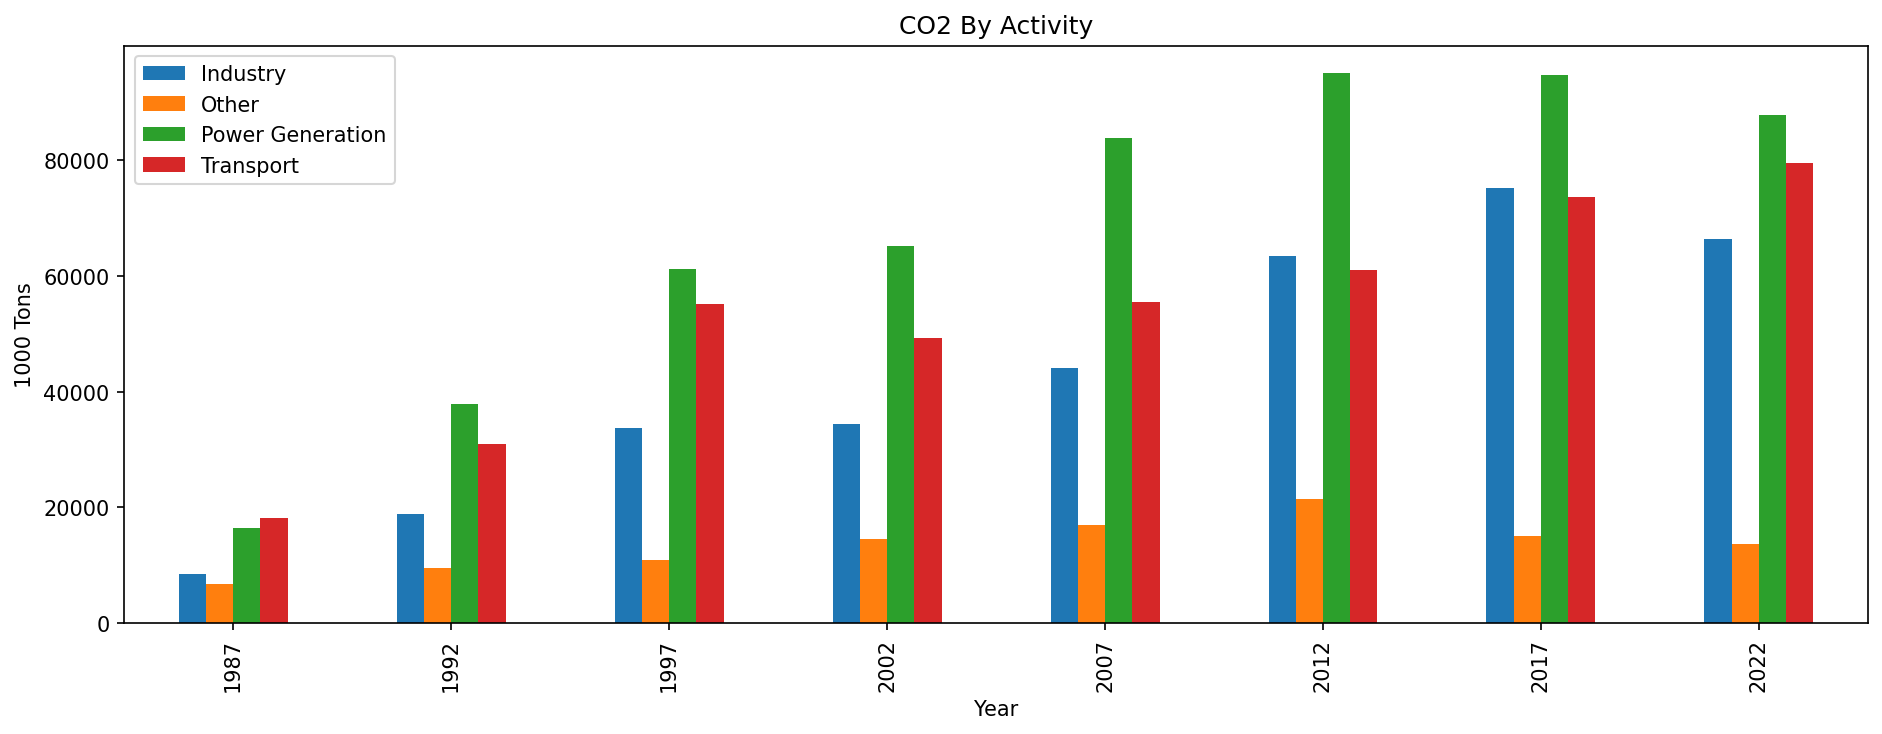

In [5]:
data_01_01['Total_Sector'] = data_01_01.drop('Total', axis =1).apply(lambda q : q['Oil'] + q['Coal/Lignite'] + q['Natural Gas'], axis = 1)
df_sect = data_01_01.loc[: , ['Year','Sector', 'Total_Sector']]
df_sect['Sector'].unique()
df_sect['Sector'] = df_sect.apply(lambda x: x['Sector'].strip(), axis = 1)
df_sect["Power Generation"] = df_sect.apply(lambda a: a["Total_Sector"] if a["Sector"] == "Power Generation" else 0, axis = 1)
df_sect["Transport"] =df_sect.apply(lambda a: a["Total_Sector"] if a["Sector"] == "Transport" else 0, axis = 1)
df_sect["Industry"] = df_sect.apply(lambda a: a["Total_Sector"] if a["Sector"] == "Industry" else 0, axis = 1)
df_sect["Other"] = df_sect.apply(lambda a: a["Total_Sector"] if a["Sector"] == "Other" else 0, axis = 1)
df_sect = df_sect.drop(['Sector', 'Total_Sector'], axis = 1)
df_sect = df_sect.pivot_table(index = ['Year'], values = ['Power Generation', 'Transport', 'Industry', 'Other'], aggfunc = 'sum')
#display(df_sect)

plt.figure(figsize=(15,5),dpi=150)
ax = plt.gca()
df_sect.iloc[::5, :].plot( kind='bar', ax=ax,
         title='CO2 By Activity', ylabel='1000 Tons' )

<AxesSubplot:title={'center':'kg-CO2/Kwh'}, xlabel='Year'>

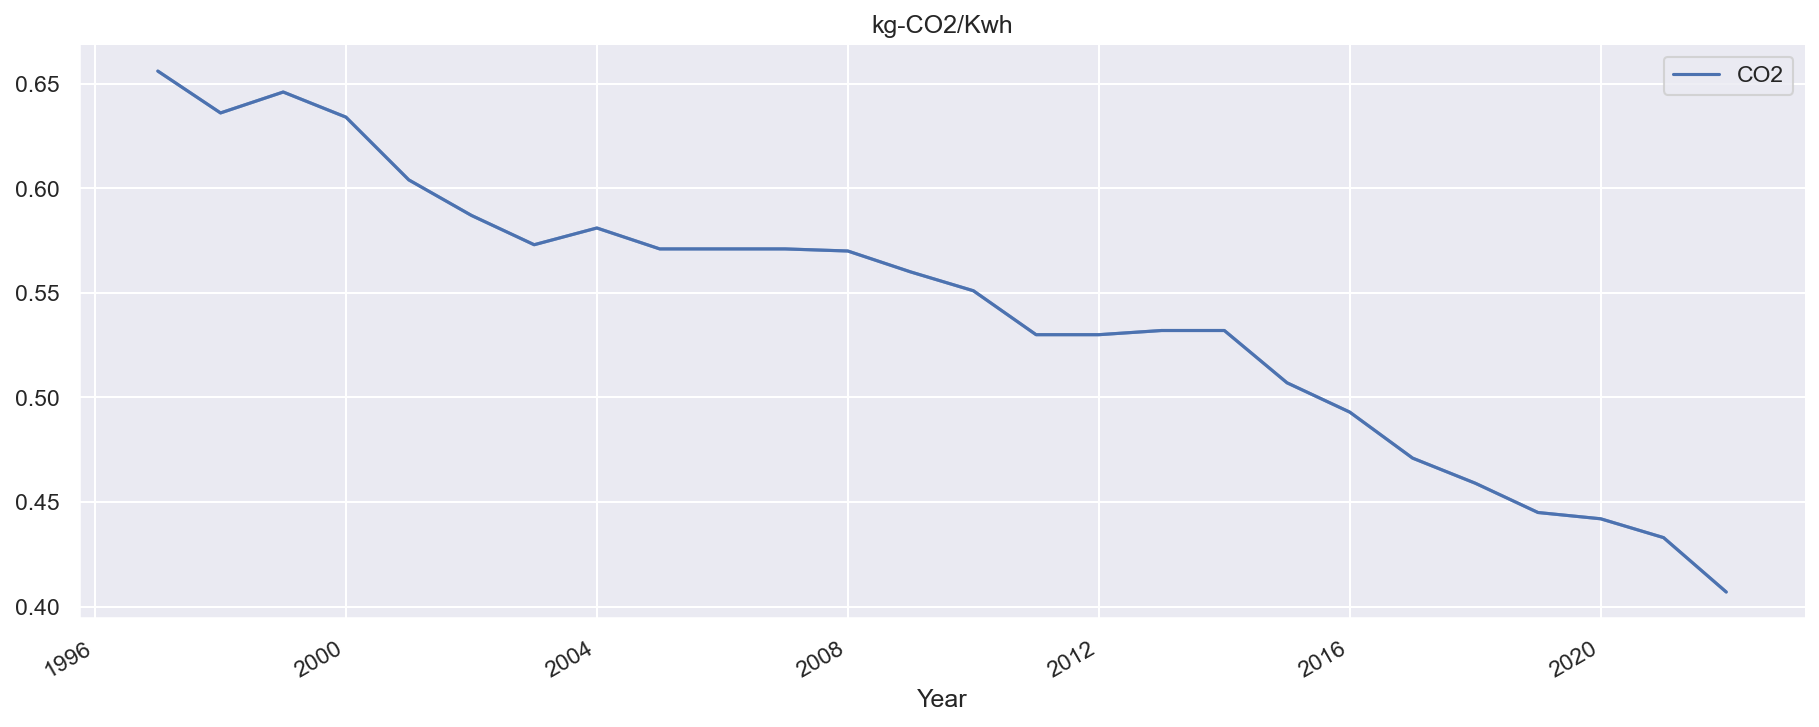

In [6]:
sns.set(rc={'figure.dpi':150})
sns.relplot( kind='line',
             data=data_01_02, 
             x='Year', y='CO2', 
             height=5, aspect=2.5,
             alpha=0.6,)

ax = plt.gca()
data_01_02.plot( kind='line', ax=ax,
         title='kg-CO2/Kwh', ylabel='')

<AxesSubplot:>

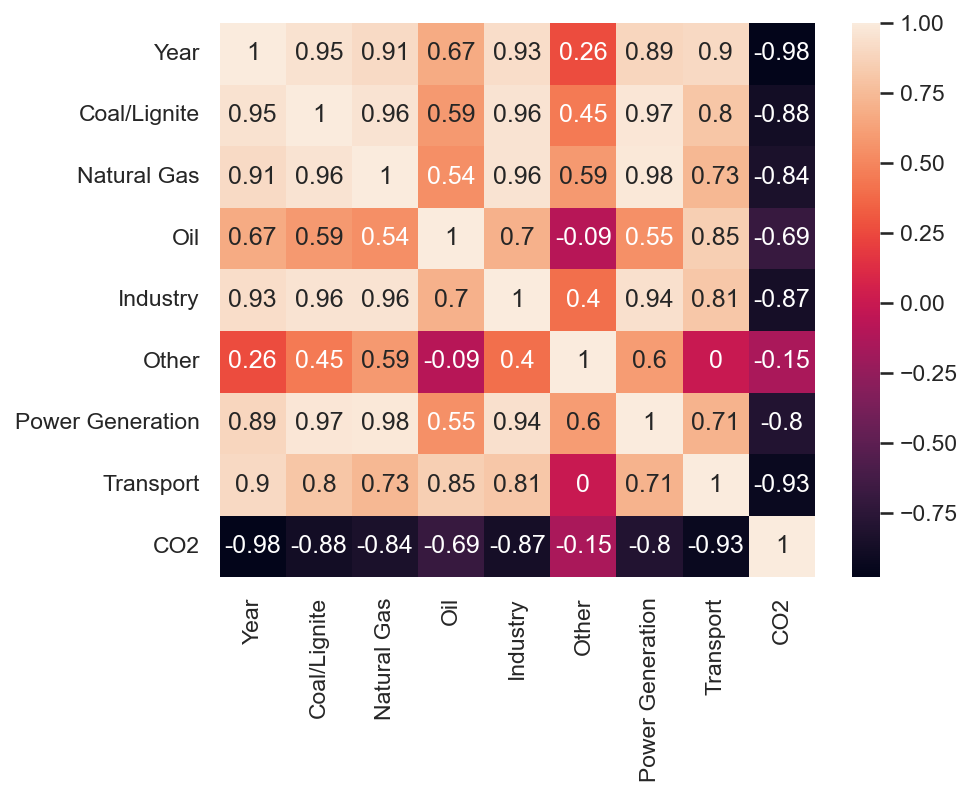

In [7]:
df_res = df_res.reset_index()
df_sect = df_sect.reset_index()
df_co2 = data_01_02.reset_index()
#display(df_res, df_sect, df_co2)

df_merg_co2 = pd.merge(df_res, df_sect, left_on = 'Year', right_on = 'Year').reset_index()
df_merg_co2 = df_merg_co2.iloc[10:,].reset_index().drop('index', axis= 1).drop('level_0', axis = 1)
df_merg_co2['CO2'] = df_co2.CO2
#display(df_merg_co2)

#feater scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
column_co2 = ['Coal/Lignite', 'Natural Gas', 'Oil', 'Power Generation', 'Transport', 'Industry', 'Other']
df_merg_co2[column_co2] = scaler.fit_transform(df_merg_co2[column_co2])
#display(df_merg_co2)

corr_CO2 = df_merg_co2.corr().round(2)
sns.heatmap(corr_CO2, annot = True)     #ทำใหม่เอาเฉพาะพลังงาน


In [8]:
df_sect = df_sect.reset_index()

<AxesSubplot:>

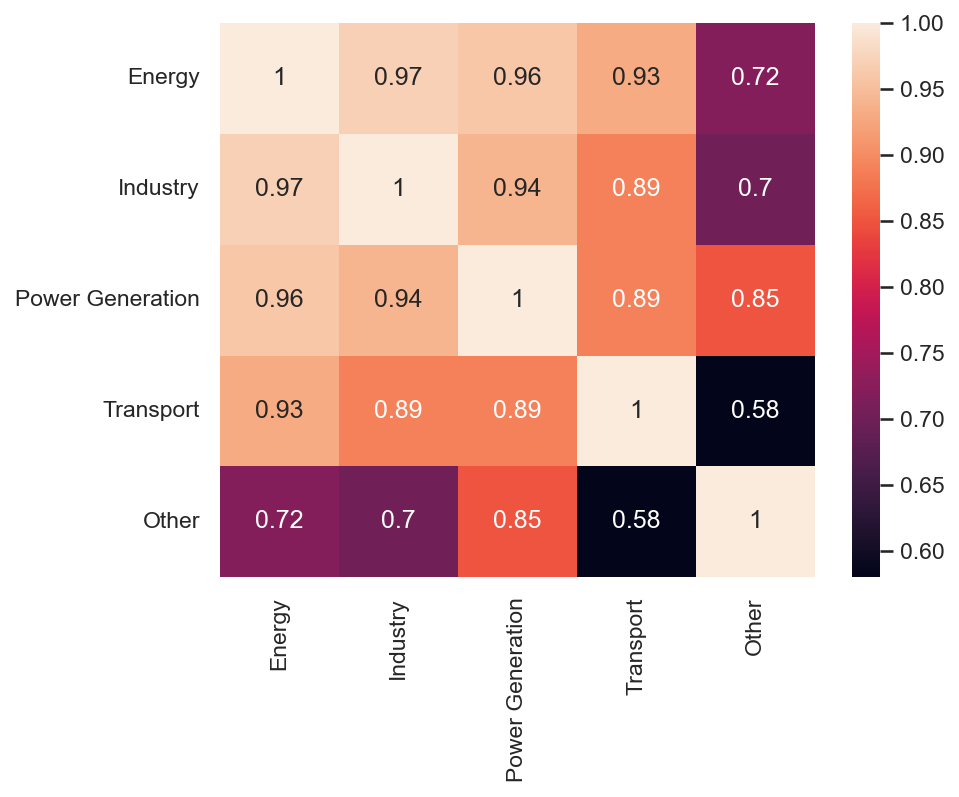

In [9]:
#display(df_sect)
#display(data_01_00)
df_merg_ener = pd.merge(df_ener, df_sect, left_on = 'Year', right_on = 'Year')
#df_merg_co2 = df_merg_co2.iloc[10:,].reset_index().drop('index', axis= 1).drop('level_0', axis = 1)
#display(df_merg_ener)

#feater scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

column_ener = ['Energy', 'Power Generation', 'Transport', 'Industry', 'Other']
df_merg_ener[column_ener] = scaler.fit_transform(df_merg_ener[column_ener])
df_merg_ener[['Energy','Industry','Power Generation', 'Transport']]

#display(df_merg_ener)

corr_ener = df_merg_ener[['Energy','Industry','Power Generation', 'Transport', 'Other']].corr().round(2)
sns.heatmap(corr_ener, annot = True) 

In [10]:
#dataset2
data_02_01 = pd.read_csv('02_Province_Oil.csv')
data_02_01['ภาค'].fillna(method='ffill', inplace = True)
data_02_01['จังหวัด'].fillna(method='ffill', inplace = True)
data_02_01.fillna(0, inplace= True) 

#data_02_01 = data_02_01.style.format("{:,.2f}", subset = ['2555', '2556', '2557', '2558', '2559', '2560', \
                                                        #'2561', '2562', '2563', '2564'])
####
#pd.reset_option('display.max_rows')                                     
#display(data_02_01)
#data_02_01.info()

In [11]:
data_02_01 = pd.read_csv('02_Province_elec.csv')
data_02_01['Region'].fillna(method='ffill', inplace = True)
data_02_01['จังหวัด'].fillna(method='ffill', inplace = True)
data_02_01['จำนวนผู้ใช้และการจำหน่าย'].fillna(method='ffill', inplace = True)
data_02_01.dropna(subset = ['ประเภทผู้ใช้'], inplace = True)
data_02_01.fillna(0, inplace= True)

#pdcer['Garbage'] = pdcer.apply(lambda x: count_type(x['Year'], 'gb'), axis = 1 )

#display(data_02_01)

<AxesSubplot:title={'center':'Rayong'}>

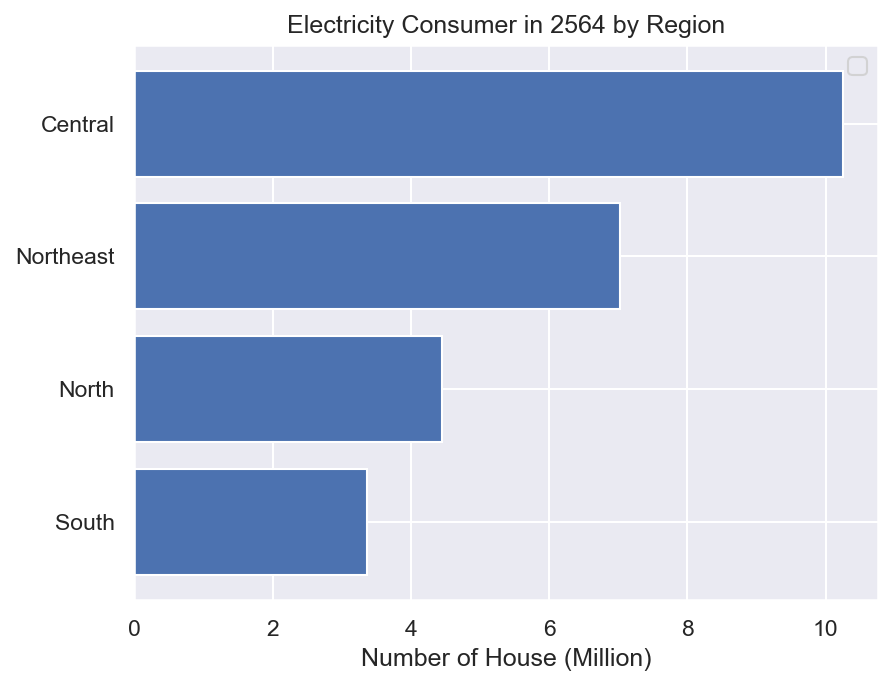

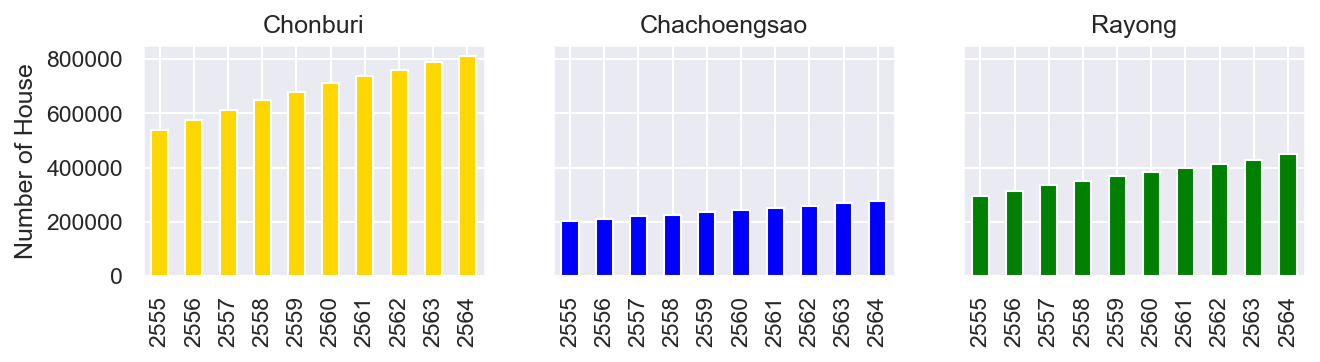

In [12]:
p0 = data_02_01[data_02_01['Region'].str.match('ภาค', case = False)]
p0 = p0[p0['จังหวัด'].str.match('ภาค', case = False)]
p0 = p0[p0['ประเภทผู้ใช้'].str.match('จำนวนผู้ใช้ไฟฟ้า', case = False)]
p0.drop(['จังหวัด', 'จำนวนผู้ใช้และการจำหน่าย', 'ประเภทผู้ใช้'], axis = 1, inplace = True)
#display(p0)

#p0.columns = p0.columns.str.replace('ภาค', 'Region')

p0 = p0.groupby('Region').sum().T
p0.columns = p0.columns.str.replace('ภาคกลาง', 'Central')
p0.columns = p0.columns.str.replace('ภาคตะวันออกเฉียงเหนือ', 'Northeast')
p0.columns = p0.columns.str.replace('ภาคเหนือ', 'North')
p0.columns = p0.columns.str.replace('ภาคใต้', 'South')
p0 = pd.DataFrame(p0)
#p0 = p0.set_index(['Region'])
#display(p0)

reg_name = ['Central', 'Northeast',	'North', 'South']
reg_volume = np.array([10.248225, 7.029429, 4.455876, 3.361232])
df_reg = pd.DataFrame(reg_name, columns= ['Region'])
df_reg['volume'] = reg_volume
df_reg.sort_values('volume', inplace = True)
#display(df_reg)
plt.barh(df_reg['Region'], df_reg['volume'])
plt.legend('')          # Add legend to the graph
plt.xlabel("Number of House (Million)")                  # Add x-labels
plt.title("Electricity Consumer in 2564 by Region")

p1 = data_02_01[data_02_01['Region'].str.match('ภาค', case = False)]
p1 = p1[p1['ประเภทผู้ใช้'].str.match('จำนวนผู้ใช้ไฟฟ้า', case = False)]
p1 = p1[p1['จังหวัด'].isin(['ชลบุรี','ฉะเชิงเทรา', 'ระยอง'])]
p1.rename(columns = {"จังหวัด":"Year"}, inplace = True)
p1.drop(['Region', 'จำนวนผู้ใช้และการจำหน่าย', 'ประเภทผู้ใช้'], axis = 1, inplace = True)

p1 = p1.set_index('Year').T
p1.rename(columns = {'ชลบุรี':'Chonburi', 'ฉะเชิงเทรา':'Chachoengsao', 'ระยอง':'Rayong'}, inplace = True)
#display(p1)

fig, ax = plt.subplots(1,3, sharex = True, sharey = True, figsize = (10,2)) #grap2

Year = []
for i in range(2555,2565):
    Year.append(str(i))

p1.loc[Year, 'Chonburi'].plot(kind = 'bar', color = 'gold', ax = ax[0], title = 'Chonburi', ylabel='Number of House')
p1.loc[Year, 'Chachoengsao'].plot(kind = 'bar', color = 'blue', ax = ax[1], title = 'Chachoengsao')
p1.loc[Year, 'Rayong'].plot(kind = 'bar', color = 'green', ax = ax[2], title = 'Rayong')



In [13]:
#dataset 03
data_03_01 = pd.read_csv('03_GreenEnergy_01.csv')
data_03_02 = pd.read_csv('03_GreenEnergy_02.csv')
#data_03_01.info()
#data_03_02.info()
data_03_01.คู่ค้าทางธุรกิจ = data_03_01.คู่ค้าทางธุรกิจ.astype('str')
data_03_01.บัญชีผู้ผลิตไฟฟ้า = data_03_01.บัญชีผู้ผลิตไฟฟ้า.astype('str')
data_03_01.บัญชีผู้ใช้ไฟฟ้า = data_03_01.บัญชีผู้ใช้ไฟฟ้า.astype('object')
data_03_01.VENDOR = data_03_01.VENDOR.astype('str')
data_03_01.year = data_03_01.year.astype('str')
#display(data_03_01)

pdcer = pd.DataFrame()
pdcer['Year'] = list(range(2550, 2565))

def count_type(year, type):
    x = data_03_01.loc[data_03_01['year'] == str(year)].loc[data_03_01['Code_Fuel_Type'] == str(type)]['Code_Fuel_Type'].count()
    return x

pdcer['Garbage']    = pdcer.apply(lambda x: count_type(x['Year'], 'gb'), axis = 1 )
pdcer['Biogas']     = pdcer.apply(lambda x: count_type(x['Year'], 'bg'), axis = 1 )
pdcer['Biomas']     = pdcer.apply(lambda x: count_type(x['Year'], 'bm'), axis = 1 )
pdcer['Solar']      = pdcer.apply(lambda x: count_type(x['Year'], 'sl'), axis = 1 )
#display(pdcer)

#pdcer_v = pd.DataFrame()
#pdcer_v['Year'] = list(range(2550, 2565))

def sum_volume(year, type):
    x = data_03_01.loc[data_03_01['year'] == str(year)].loc[data_03_01['Code_Fuel_Type'] == str(type)]['ปริมาณเสนอขาย(MW)'].sum()
    return x
#print(sum_volume(2555, 'bg'))

#pdcer_v['Garbage']  = pdcer_v.apply(lambda x: sum_volume(x['Year'], 'gb'), axis = 1 )
#pdcer_v['Biogas']   = pdcer_v.apply(lambda x: sum_volume(x['Year'], 'bg'), axis = 1 )
#pdcer_v['Biomas']   = pdcer_v.apply(lambda x: sum_volume(x['Year'], 'bm'), axis = 1 )
#pdcer_v['Solar']    = pdcer_v.apply(lambda x: sum_volume(x['Year'], 'sl'), axis = 1 )
#display(pdcer_v)

<AxesSubplot:title={'center':'Volume of Green Energy'}, xlabel='year', ylabel='(MW)'>

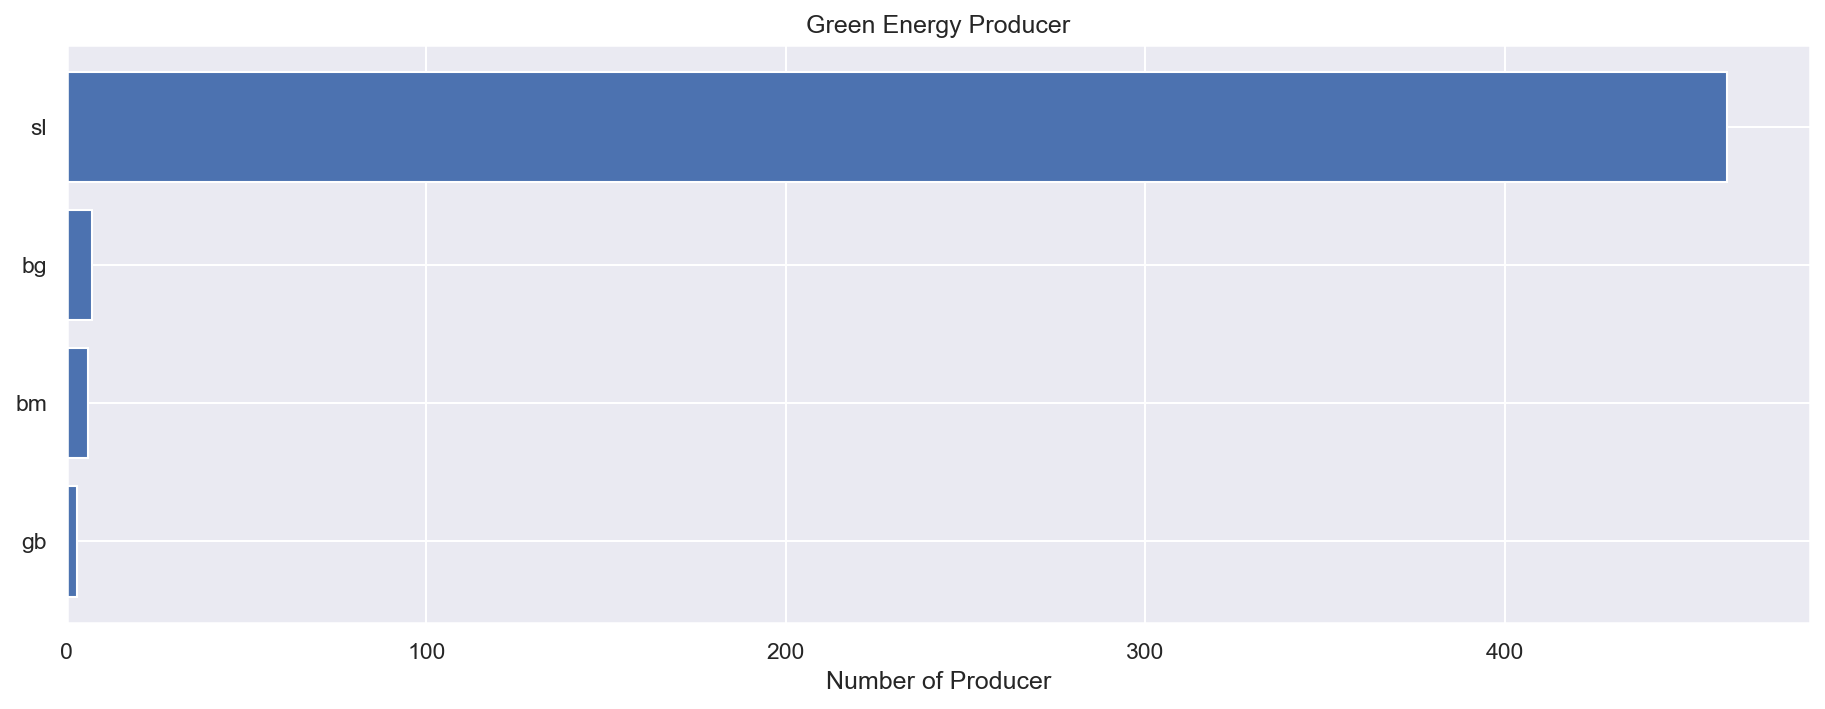

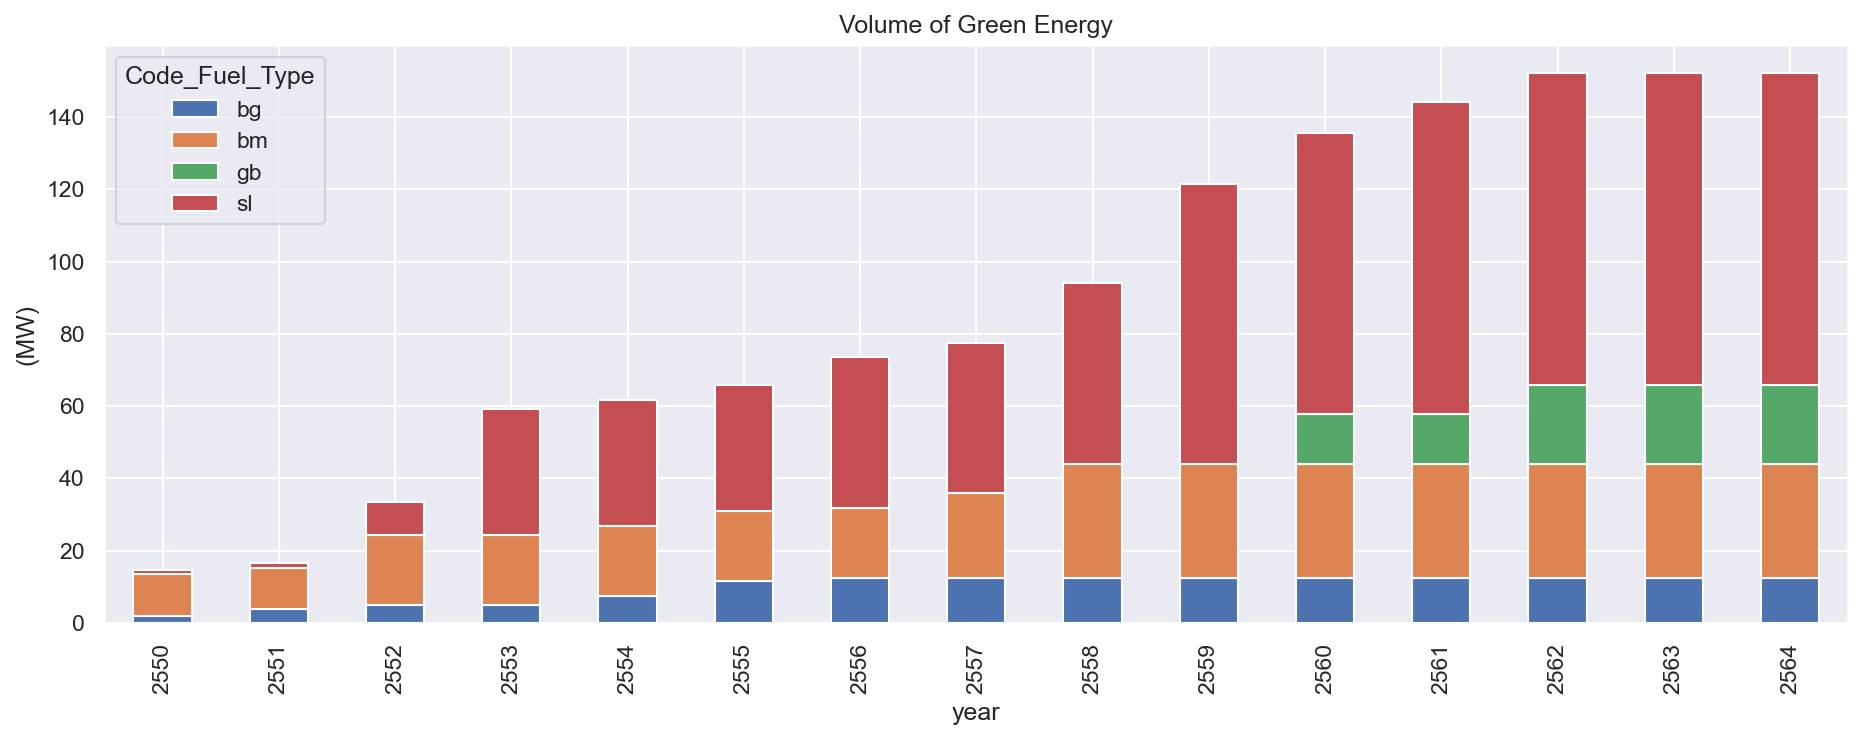

In [14]:
pvt = data_03_01.pivot_table(index = ['year'], columns = ['Code_Fuel_Type'], values = ['VENDOR'], aggfunc = 'count',fill_value = 0)
#display(pvt)
prod = pvt['VENDOR']
prod = prod[['bg','bm', 'gb', 'sl']].cumsum()
#display(prod)
#prod.plot.bar()

plt.figure(figsize=(15,5),dpi=150)
reg_name = ['bg', 'bm',	'gb', 'sl']
reg_volume = np.array([7, 6, 3, 462])
df_reg = pd.DataFrame(reg_name, columns= ['Region'])
df_reg['volume'] = reg_volume
df_reg.sort_values('volume', inplace = True)
#display(df_reg)
plt.barh(df_reg['Region'], df_reg['volume'])
plt.title('Green Energy Producer')
plt.xlabel("Number of Producer")                  # Add x-labels
plt.ylabel("")

pvt = data_03_01.pivot_table(index = ['year'], columns = ['Code_Fuel_Type'], values = ['ปริมาณเสนอขาย(MW)'], aggfunc = 'sum',fill_value = 0)
volume_mw = pvt['ปริมาณเสนอขาย(MW)']
volume_mw = volume_mw[['bg','bm', 'gb', 'sl']].cumsum()
#display(volume_mw)

plt.figure(figsize=(15,5),dpi=150)
ax = plt.gca()
volume_mw.plot(kind = 'bar', stacked =True, ax=ax,
                        title='Volume of Green Energy', ylabel='(MW)')


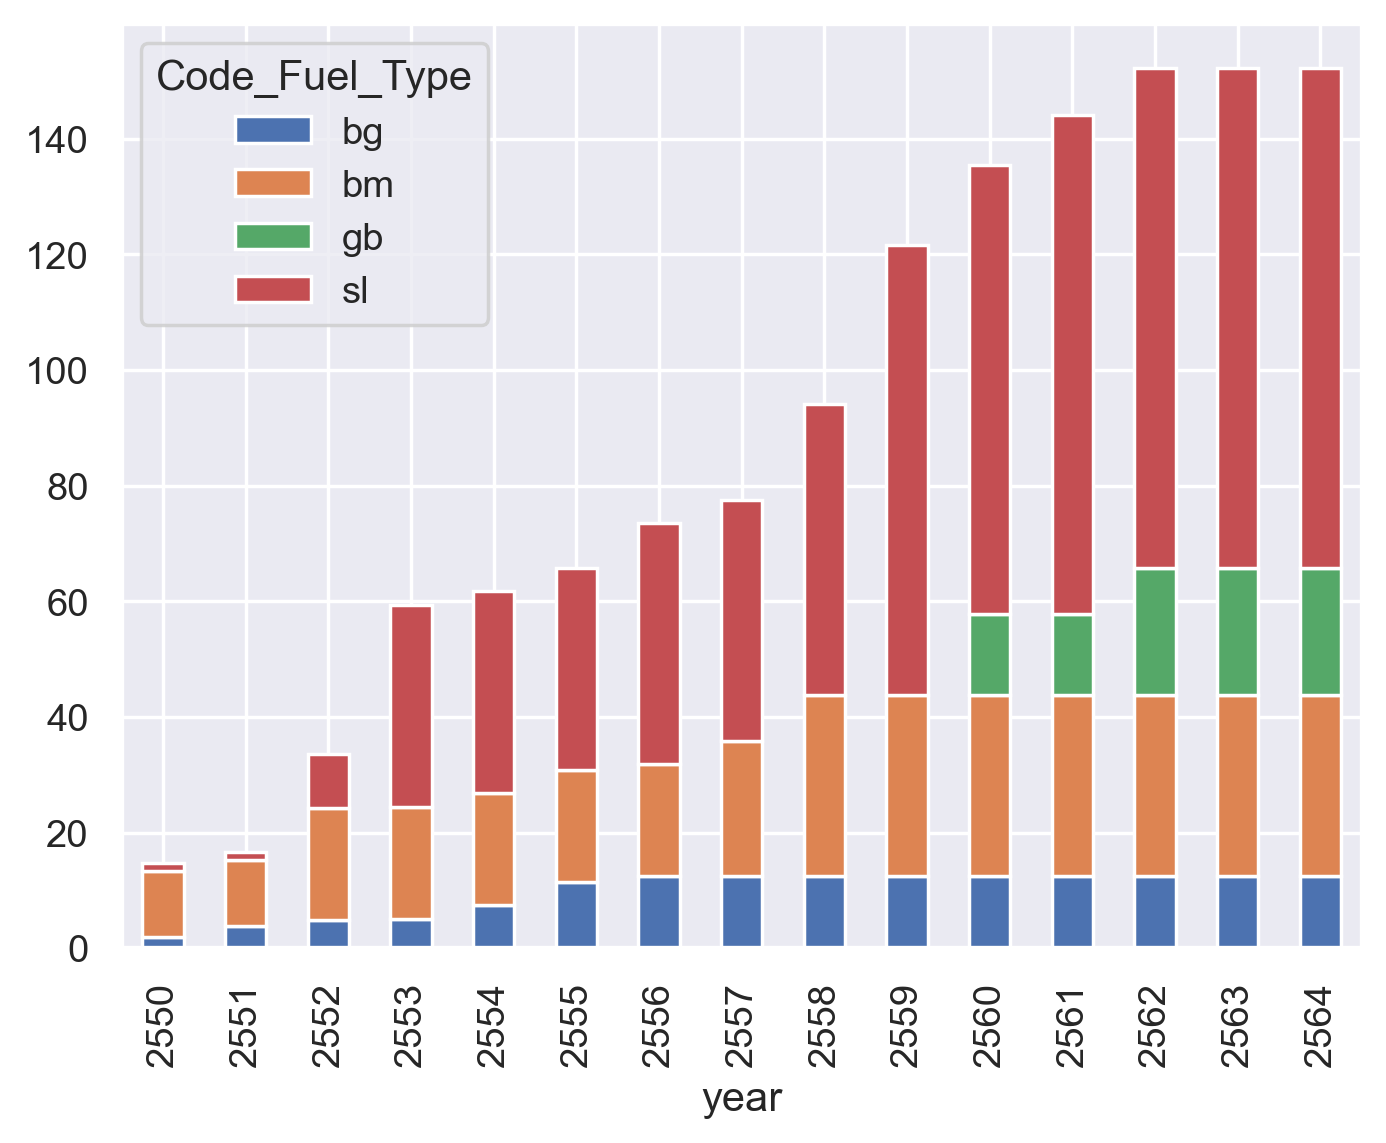

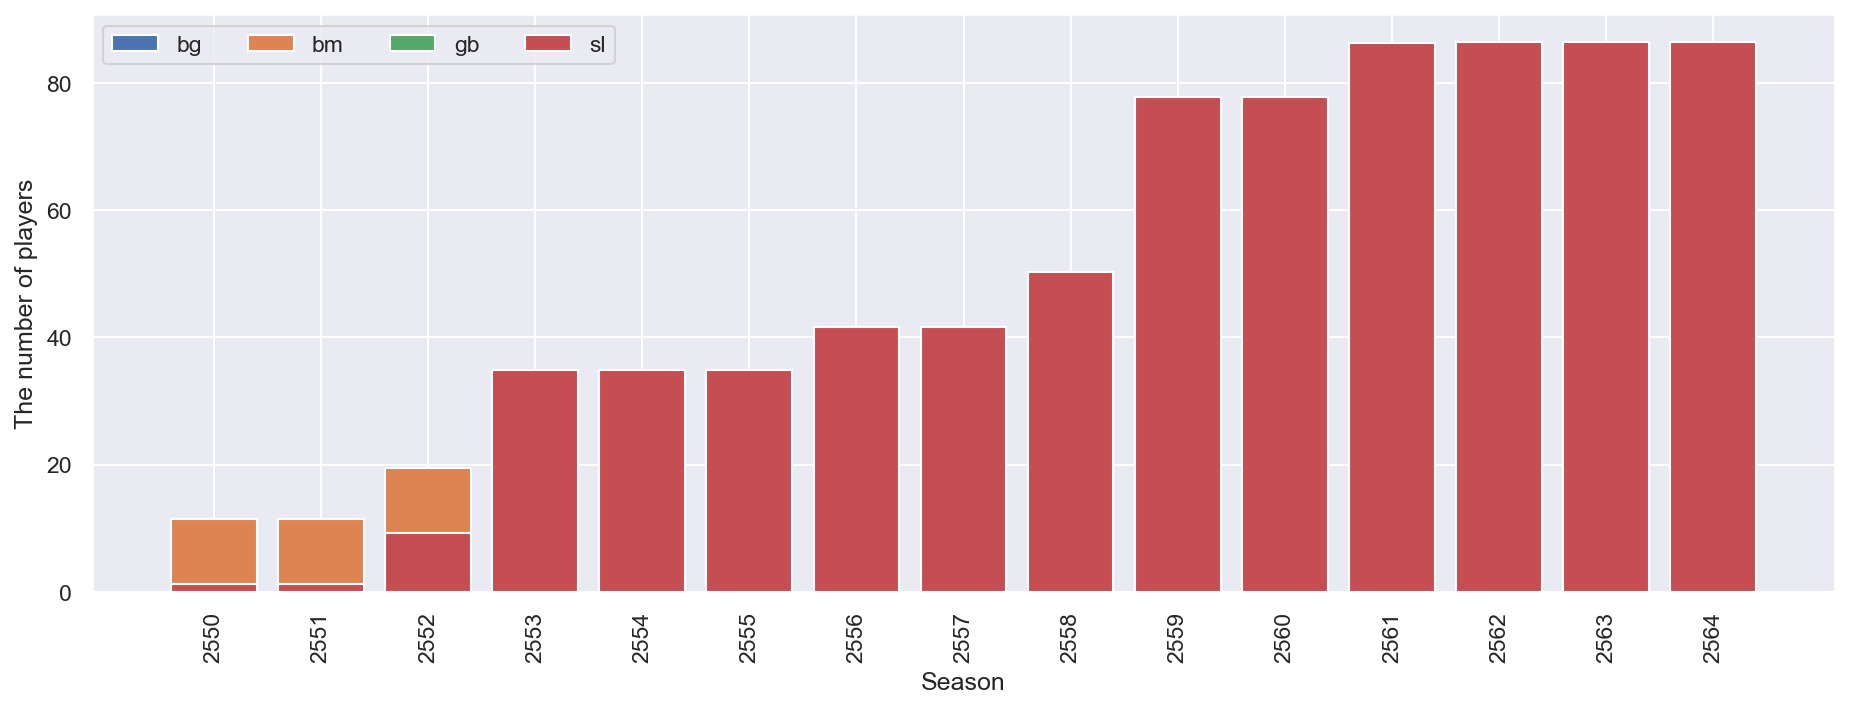

In [21]:
pvt = data_03_01.pivot_table(index = ['year'], columns = ['Code_Fuel_Type'], values = ['ปริมาณเสนอขาย(MW)'], aggfunc = 'sum',fill_value = 0)
volume_mw = pvt['ปริมาณเสนอขาย(MW)']
volume_mw = volume_mw[['bg','bm', 'gb', 'sl']].cumsum()
#display(volume_mw)

volume_mw.plot(kind = 'bar', stacked =True)

plt.figure(figsize=(15,5),dpi=150)

# Plot 
plt.bar( x=volume_mw.index,            # season
           height=volume_mw['bg'],  # the number of players
           label='bg' )
plt.bar( x=volume_mw.index,            # season
           height=volume_mw['bm'],  # the number of players
           label='bm' )
plt.bar( x=volume_mw.index,            # season
           height=volume_mw['gb'],  # the number of players
           label='gb' )
plt.bar( x=volume_mw.index,            # season
           height=volume_mw['sl'],  # the number of players
           label='sl' )

# (Optional) Add legend to the graph
plt.legend(loc='upper left',      # Place legend at which location 
           ncol=len(volume_mw.columns))  # How many columns to diplay the legend (default=1)  

# (Optional) Add labels to x and y axes
plt.xlabel("Season")                  
plt.ylabel("The number of players")   

# Rotate labels in x-axis to avoid text overlapping
_ = plt.setp( plt.gca().get_xticklabels(),    # Set one or more properties regarding this artist object
              rotation=90, horizontalalignment='center' )

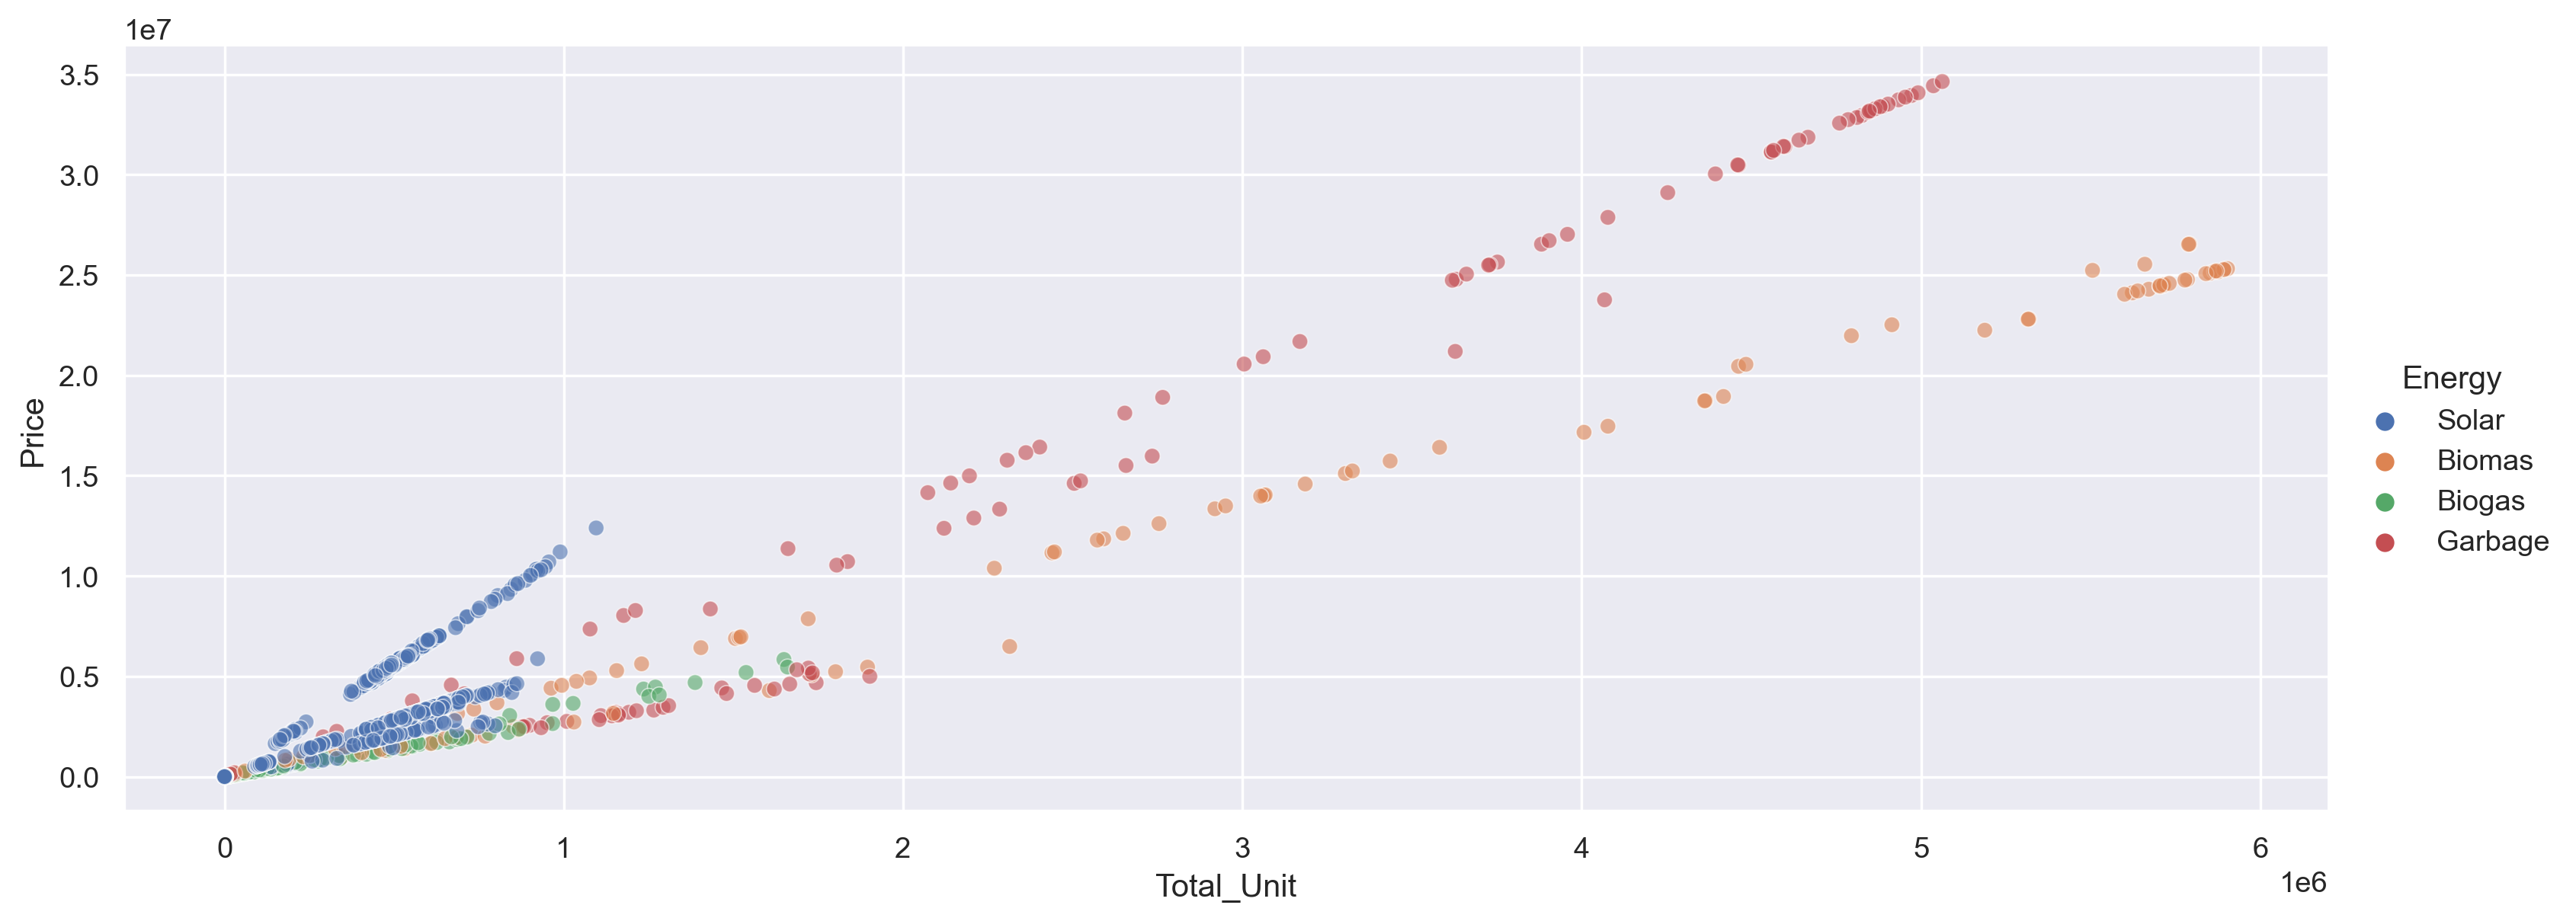

In [36]:
#display(data_03_02)
sns.set(rc={'figure.dpi':250})
sns.relplot( kind='scatter',          # default:'scatter'
             data=data_03_02,            # Data to plot
             x='Total_Unit', y='Price', # Positions of x and y axes
             hue='Energy',            # Grouping variable that will produce elements with different colors
             height=5, aspect=2.5,    # Figure size must be set in the figure-level function
             alpha=0.6,
            ) 

,ลำดับ,รหัสการไฟฟ้า,Date,BP,CA,Energy,หมวดอัตรา,Total_Unit,Price,KW_Max,project
0,1,H05104,1.2020,1002408420,82000030004,Solar,VSPP-RN-2,107000,360164,650,adder
1,2,H07101,1.2020,1002258496,82000030013,Solar,VSPP-RN-1,0,0,0,adder
2,3,H08101,1.2020,1001319240,82000030002,Biomas,VSPP-RN-2,729000,2068727,2166,adder
3,4,H08301,1.2020,1001319541,82000030003,Biomas,VSPP-RN-2,1895200,5460196,5432,adder
4,5,H08301,1.2020,1002118923,82000030011,Biogas,VSPP-RN-1,0,0,0,adder
...,...,...,...,...,...,...,...,...,...,...,...
14360,124,H22101,7.2022,1001513530,82000296610,Solar,RTFITRD2,253,557,3,solar 62
14361,125,H22101,7.2022,1001755937,82000293405,Solar,RTFITRD2,152,334,2,solar 62
14362,126,H22101,7.2022,1002103944,82000295271,Solar,RTFITRD2,128,282,2,solar 62
14363,127,H22101,7.2022,1019210371,82000296417,Solar,RTFITRD2,278,612,3,solar 62


<Figure size 2250x7650 with 0 Axes>

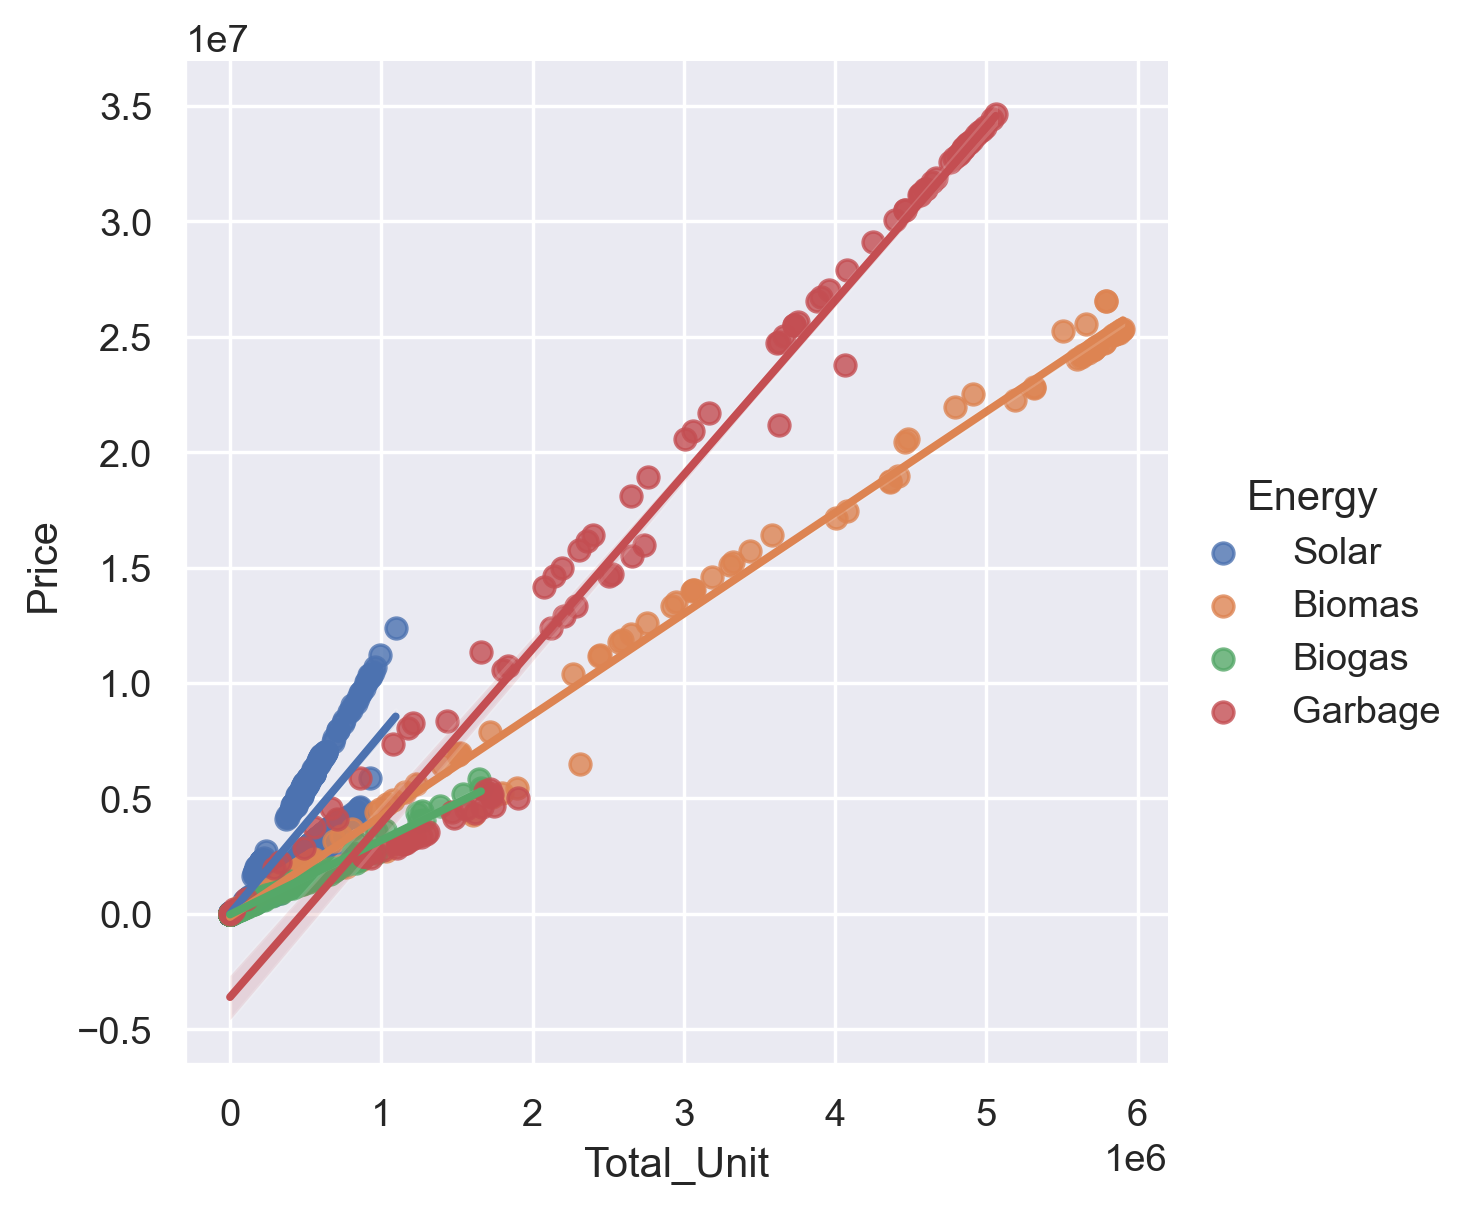

In [48]:

plt.figure(figsize=(15,51), dpi=150)
display(data_03_02)
sns.set(rc={'figure.dpi':250})
sns.lmplot( x='Total_Unit', y ='Price', data = data_03_02, hue = 'Energy'
            ) 

In [24]:
#dataset 04

#กราฟแท่ง ค่าไฟไม่รวมFt กับค่า Ft
data_04_01 = pd.read_csv('04_my_home_01.csv')
data_04_01.รหัสอัตรา = data_04_01.รหัสอัตรา.astype('str')
data_04_01.วันที่อ่าน = pd.to_datetime(data_04_01.วันที่อ่าน)
data_04_01.rename(columns = {'วันที่อ่าน': 'Date'}, inplace= True)
data_04_01.rename(columns = {'KWH รวม': 'KWH'}, inplace= True)
data_04_01.rename(columns = {'ค่า FT': 'Ft_Price'}, inplace= True)
data_04_01.rename(columns = {'FT / หน่วย': 'Ft_Rate'}, inplace= True)
data_04_01.rename(columns = {'ค่าไฟฟ้ารวมภาษี': 'Price_Bt'}, inplace= True)
data_04_01.rename(columns = {'เฉลี่ย/หน่วย': 'Price/Unit'}, inplace= True)
data_04_01.set_index('Date', inplace = True)
#data_04_01.info()
#display(data_04_01)

C:\Users\tanat\AppData\Local\Temp\ipykernel_25212\643971810.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data_04_01.วันที่อ่าน = pd.to_datetime(data_04_01.วันที่อ่าน)


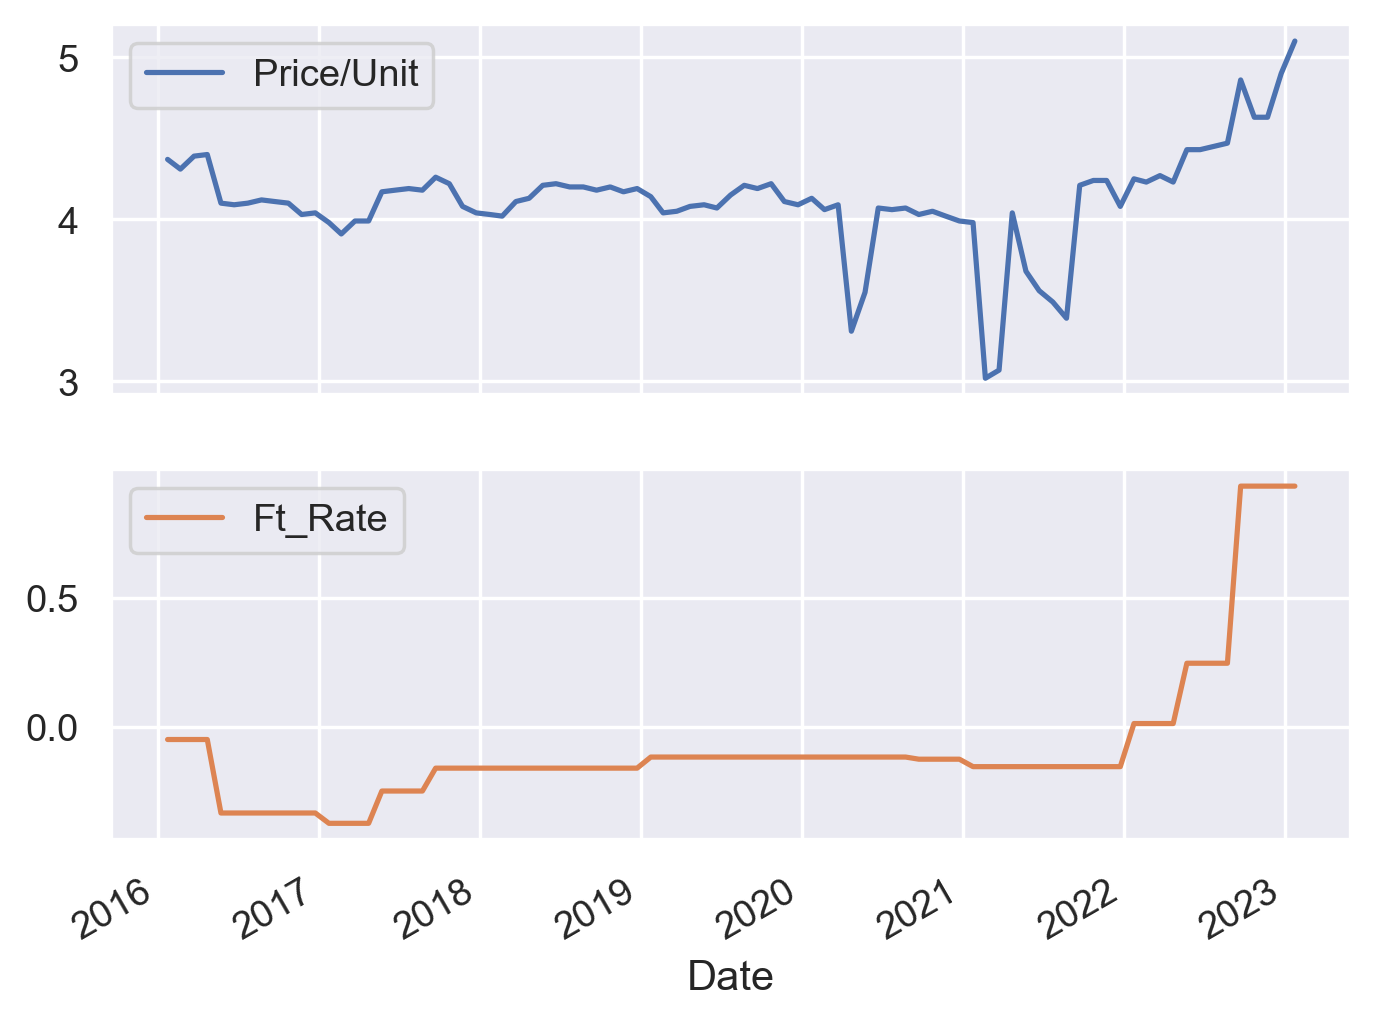

In [18]:
data_04_01[['Price/Unit', 'Ft_Rate']].loc['2016':'2023'].plot(subplots= True, grid = True)
#plt.ylabel('Bath/Unit');
plt.show()

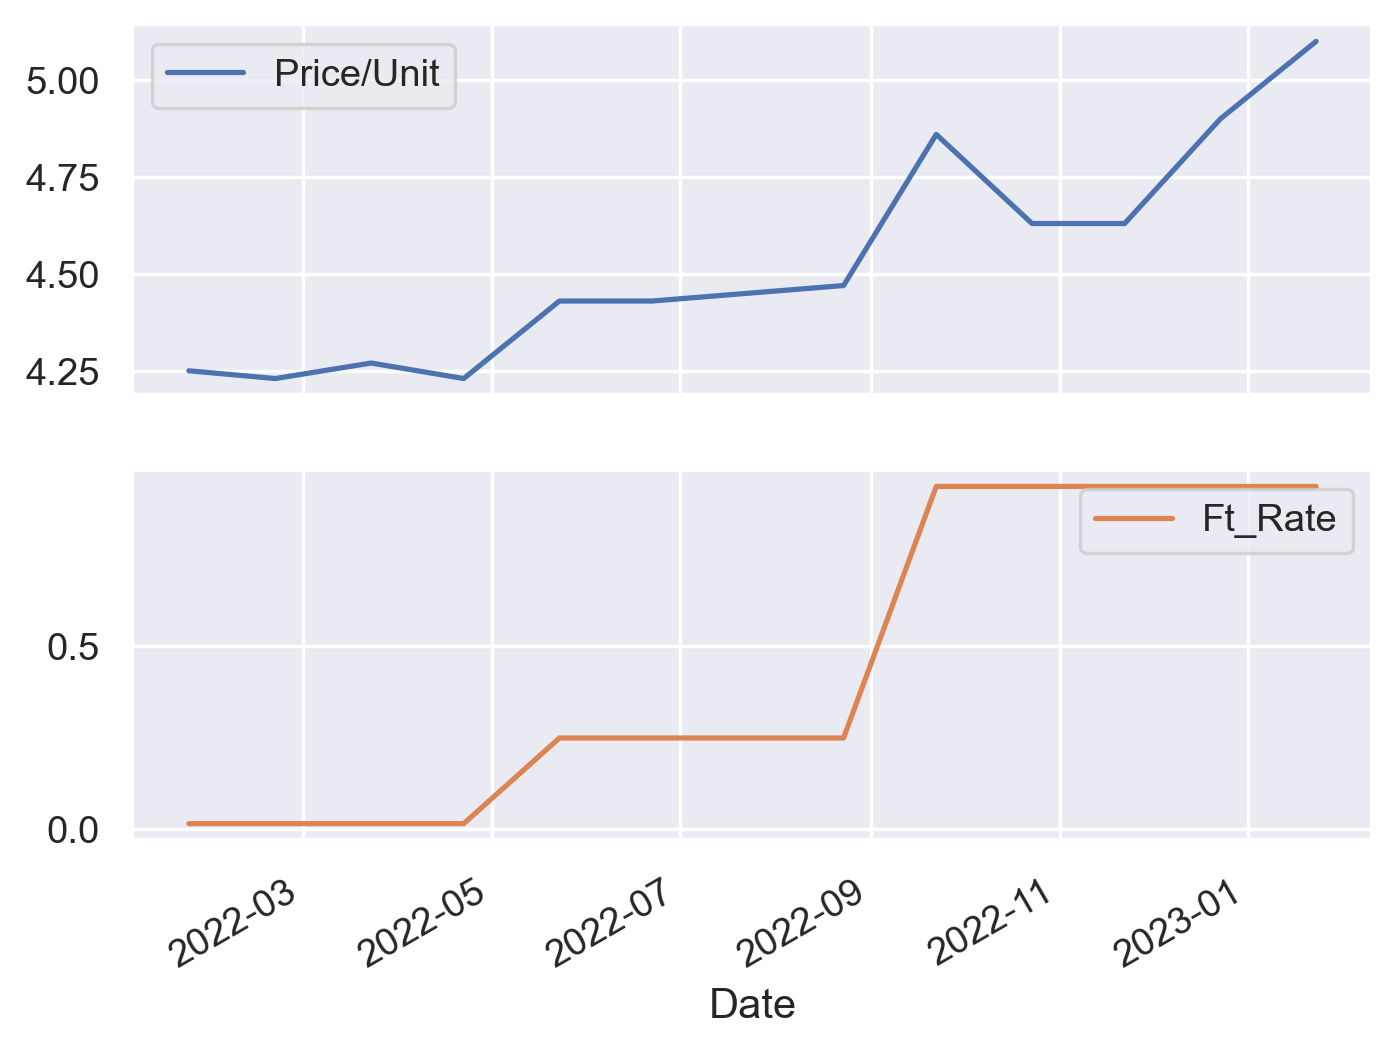

In [19]:
data_04_01[['Price/Unit', 'Ft_Rate']].loc['2022':'2023'].plot(subplots= True, grid = True)
#plt.ylabel('Bath/Unit');
plt.show()

In [26]:
#Investment #ความคุ้มค่าด้านการลงทุน NPV IRR

#display(data_04_01['Price/Unit'][84:96]) 
power = 5
use = round(data_04_01['KWH'][84:96].mean()/30/4.2/0.7,2) 
price_h = round(data_04_01['Price/Unit'][84:96].mean(),2) #
price_s = 2.20
y0 = -200000
yn = (use*4.2*365*price_h)+((power-use)*4.2*365*price_s)
age_s = 20

cashflows = [y0]

for i in range(1,(age_s)+1):
    cashflows.append(yn)
#print(cashflows)
rate = 0.05

npv_sl = npf.npv(rate, cashflows)
irr_sl = npf.irr(cashflows)

def dpp(rate, cash_flows=list()):
    #from pandas import Series, DataFrame
    cf_df = pd.DataFrame(cash_flows, columns=['UndiscountedCashFlows'])
    cf_df.index.name = 'Year'
    cf_df['DiscountedCashFlows'] = npf.pv(rate=rate, pmt=0, nper=cf_df.index, fv=-cf_df['UndiscountedCashFlows'])
    cf_df['CumulativeDiscountedCashFlows'] = np.cumsum(cf_df['DiscountedCashFlows'])
    final_full_year = cf_df[cf_df.CumulativeDiscountedCashFlows < 0].index.values.max()
    fractional_yr = -cf_df.CumulativeDiscountedCashFlows[final_full_year ]/cf_df.DiscountedCashFlows[final_full_year + 1]
    payback_period = final_full_year + fractional_yr
    return payback_period
dpp_sl = dpp(rate, cashflows)

#print(npv_sl, irr_sl, dpp_sl)

from tabulate import tabulate

head = ['Parameter', 'Quantity', 'Unit']
data = [('Consumption', use, 'Kw/Day'),
        ('Capacity', power, 'Kw/Day'),
        ('Elec Price of House', price_h, 'Baht/KwH'),
        ('Elec Price of Solar', price_s, 'Baht/KwH'),
        ('Age of Solar Panel', age_s, 'Year'),
        ('', '', ''),
        ('Cost', cashflows[0], 'Baht'),
        ('Benefit', round(cashflows[1],2), 'Baht/Year'),
        ('Inflation Rate', rate*100, '%'),
        ('', '', ''),
        ('NPV', round(npv_sl, 2), 'Baht'),
        ('IRR', round(irr_sl*100, 2), '%'),
        ('Payback Period', round(dpp_sl, 2), 'Year')]
print(tabulate(data, head, tablefmt = 'psql', floatfmt = ',.0f', numalign = 'right'))

+---------------------+------------+-----------+
| Parameter           | Quantity   | Unit      |
|---------------------+------------+-----------|
| Consumption         | 4.15       | Kw/Day    |
| Capacity            | 5          | Kw/Day    |
| Elec Price of House | 4.48       | Baht/KwH  |
| Elec Price of Solar | 2.2        | Baht/KwH  |
| Age of Solar Panel  | 20         | Year      |
|                     |            |           |
| Cost                | -200000    | Baht      |
| Benefit             | 31368.25   | Baht/Year |
| Inflation Rate      | 5.0        | %         |
|                     |            |           |
| NPV                 | 190917.68  | Baht      |
| IRR                 | 14.67      | %         |
| Payback Period      | 7.87       | Year      |
+---------------------+------------+-----------+


<AxesSubplot:>

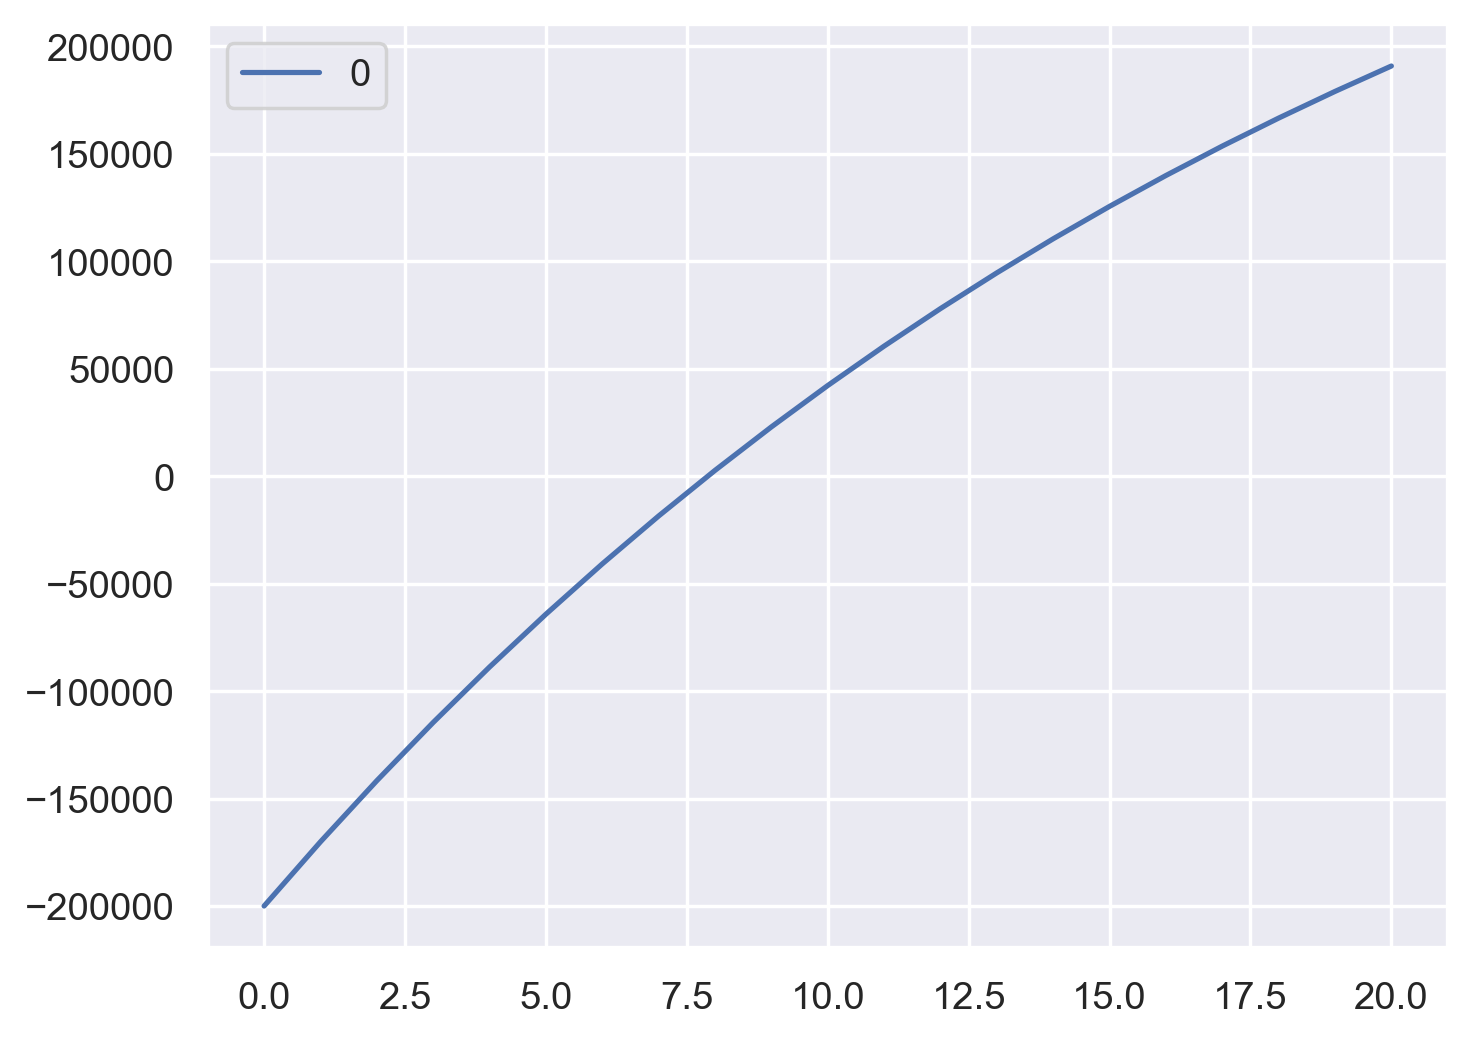

In [34]:
def dpp(rate, cash_flows=list()):
    #from pandas import Series, DataFrame
    cf_df = pd.DataFrame(cash_flows, columns=['UndiscountedCashFlows'])
    cf_df.index.name = 'Year'
    cf_df['DiscountedCashFlows'] = npf.pv(rate=rate, pmt=0, nper=cf_df.index, fv=-cf_df['UndiscountedCashFlows'])
    cf_df['CumulativeDiscountedCashFlows'] = np.cumsum(cf_df['DiscountedCashFlows'])
    return list(cf_df['CumulativeDiscountedCashFlows'])
dpp_sl = dpp(rate, cashflows)
df_dpp = pd.DataFrame(dpp_sl)
df_dpp.plot.line()